 ## Defining the problem and assembling a dataset

- Kaggle Rain in Australia
  - https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
- Binary Classification Problem

 ## Choosing a measure of success

- Balanced Accuracy Score
- Precision and Recall
- AUC

## Deciding on an evaluation protocol

- Maintaining a hold-out validation set
- Doing K-fold cross-validation

## Preparing your data

In [128]:
import pandas as pd
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [396]:
weather = pd.read_csv('weatherAUS.csv')

weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [131]:
weather.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [ ]:
weather.describe()

In [138]:
NUMERICAL_VARIABLES = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 
                       'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
                       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
                       'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

In [140]:
weather.drop(NUMERICAL_VARIABLES, axis=1).describe(include=object)

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,145460,145460,135134,134894,141232,142199,142193
unique,3436,49,16,16,16,2,2
top,2013-11-12,Canberra,W,N,SE,No,No
freq,49,3436,9915,11758,10838,110319,110316


In [142]:
CATEGORICAL_VARIABLES = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [153]:
# Drop rows where target variables are missing or the locations are missing
weather = weather[~weather['RainTomorrow'].isnull() & ~weather['Location'].isnull()]

In [187]:
COLUMNS = CATEGORICAL_VARIABLES + NUMERICAL_VARIABLES

features = weather[COLUMNS]

TARGET_VARIABLE = 'RainTomorrow'
target = weather[TARGET_VARIABLE]

In [163]:
TEST_SIZE = 0.15

(XF_train, XF_test, 
 yf_train, yf_test) = train_test_split(features, 
                                       target, 
                                       test_size=TEST_SIZE, stratify=target,
                                       shuffle=True, random_state=SEED)

In [165]:
# Imputing missing value for numerical features
knn_imp = KNNImputer(n_neighbors=5).fit(XF_train[NUMERICAL_VARIABLES])

NF_train = knn_imp.transform(XF_train[NUMERICAL_VARIABLES])
NF_test = knn_imp.transform(XF_test[NUMERICAL_VARIABLES])

In [177]:
CF_train = XF_train[CATEGORICAL_VARIABLES].fillna('Unknown')
CF_test = XF_test[CATEGORICAL_VARIABLES].fillna('Unknown')

In [178]:
XC_train = pd.DataFrame(data = np.hstack((NF_train, CF_train)), 
                        columns = NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES)

XC_test = pd.DataFrame(data = np.hstack((NF_test, CF_test)), 
                        columns = NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES)

In [180]:
preprocessor = ColumnTransformer([
    ('one-hot-encoder', OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_VARIABLES),
    ('standard_scaler', StandardScaler(), NUMERICAL_VARIABLES)])

_ = preprocessor.fit(XC_train)

In [181]:
X_train, X_test = preprocessor.transform(XC_train), preprocessor.transform(XC_test)

In [182]:
label_encoder = LabelEncoder()
label_encoder.fit(yf_train)

y_train = label_encoder.transform(yf_train)
y_test = label_encoder.transform(yf_test)

In [185]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=VALIDATION_SIZE, stratify=y_train,
                                                  shuffle=True, random_state=SEED)

##  Developing a model that does better than a baseline

In [188]:
counts = weather.groupby([TARGET_VARIABLE])[TARGET_VARIABLE].count()

counts

RainTomorrow
No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

In [189]:
baseline = counts.iloc[0] / counts.sum()

baseline

0.7758187815152645

In [408]:
balanced_accuracy_score(y_train, np.zeros(len(y_train)))

0.5

In [191]:
# MLP Model Instatiation
def deep_neural_network(hidden_layers=0, hidden_neurons=np.nan, activation=None,
                        dropout=np.nan, input_dimension=2, output_dimension=1,
                        optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'],
                        name=None) :
    
    model = Sequential()
    for layer in range(hidden_layers) :
        model.add(Dense(hidden_neurons, 
                  activation=activation, 
                  input_shape='default' if layer>1 else (input_dimension,)))
        if ~np.isnan(dropout) :
            model.add(Dropout(dropout))
        
    model.add(Dense(output_dimension, 
                    activation='sigmoid' if output_dimension==1 else 'softmax',
                    input_shape='default' if hidden_layers>0 else (input_dimension,)))
  
    if name is not None :
        model._name = name
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [192]:
# Fitting MLP Classification Model
def train_deep_neural_network(model, X, y, 
                              class_weights,
                              batch_size=32, epochs=100, 
                              val_data=None, callbacks=[], seed=0) :
    
    if val_data is None :
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                          random_state=seed, shuffle=True, 
                                                          stratify=y)
        
    else :
        X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]
  

    history = model.fit(X_train, y_train,
                        class_weight=class_weights,
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=0)

    return {'model': model, 
            'val_score': model.evaluate(X_val, y_val, verbose=0)[1:], 
            'history': history }

In [193]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_DIMENSION = 1

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

In [255]:
slp_model = deep_neural_network(hidden_layers=0, 
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_DIMENSION,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Single_Layer_Perceptron')

slp_model.summary()

Model: "Single_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 1)                 120       
                                                                 
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [312]:
batch_size = 512
EPOCHS = 100

MONITOR = 'val_loss'
PATIENCE = 5

EARLY_STOP = EarlyStopping(monitor=MONITOR, restore_best_weights=True, patience=PATIENCE, verbose=0)

In [257]:
weights = compute_class_weight('balanced', classes=np.unique(labels), y=y_train)
CLASS_WEIGHTS = dict(enumerate(weights))

CLASS_WEIGHTS

{0: 0.6444814234469898, 1: 2.2303262525768575}

In [258]:
trained_slp_model = train_deep_neural_network(slp_model, X_train, y_train,
                                              CLASS_WEIGHTS,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

In [259]:
print('Accuracy (Validation): {:.2f} (baseline=0.77)'.format(trained_slp_model['val_score'][0]))
print('Precision (Validation): {:.2f}'.format(trained_slp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_slp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_slp_model['val_score'][3]))

Accuracy (Validation): 0.80 (baseline=0.77)
Precision (Validation): 0.54
Recall (Validation): 0.78
AUC (Validation): 0.88


In [409]:
preds = (trained_slp_model['model'].predict(X_val, verbose=0) > 0.5).astype('int32')

print('Balanced Accuracy (Validation): {:.2f} (baseline = 0.5)'.format(balanced_accuracy_score(y_val, preds)))

Balanced Accuracy (Validation): 0.79 (baseline = 0.5)


In [261]:
def plot_training_history(history, monitors=['loss', 'AUC']) :

  # using the variable axs for multiple Axes
  fig, axs = plt.subplots(1, 2, sharex='all', figsize=(15,5))
 
  for ax, monitor in zip(axs.flat, monitors) :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    if monitor == 'loss' :
      monitor = monitor.capitalize()

    epochs = range(1, len(loss)+1)

    ax.plot(epochs, loss, 'b.', label=monitor)
    ax.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    ax.set_xlim([0, len(loss)])
    ax.title.set_text('Training and Validation ' + monitor + 's')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()
    ax.grid()

  _ = plt.show()

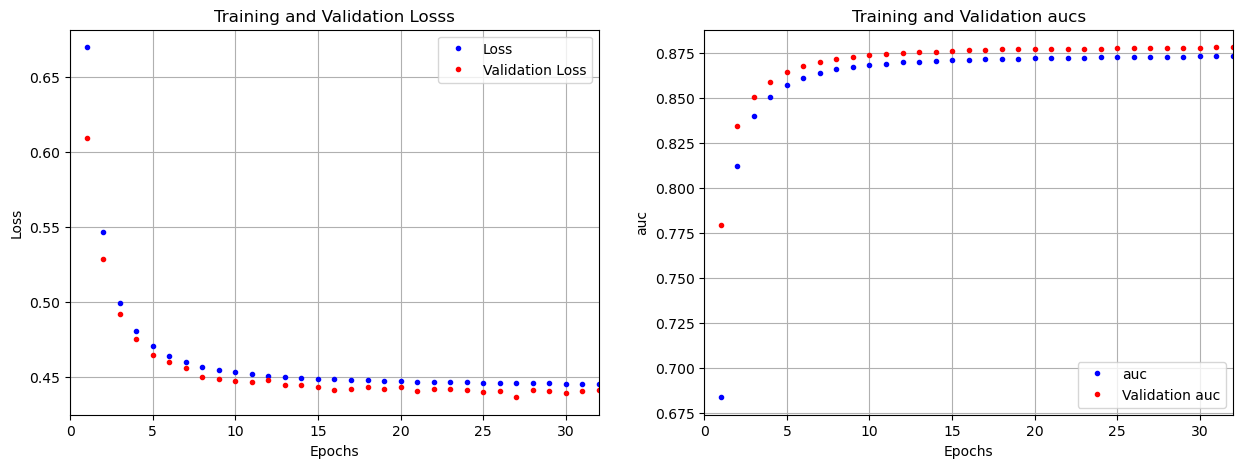

In [415]:
plot_training_history(trained_slp_model['history'], monitors=['loss', 'auc'])

 ## Scaling up: developing a model that overfits

In [322]:
mlp_model = deep_neural_network(hidden_layers=2, hidden_neurons=80,
                                activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_DIMENSION,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Multi_Layer_Perceptron')

mlp_model.summary()

Model: "Multi_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 80)                9600      
                                                                 
 dense_67 (Dense)            (None, 80)                6480      
                                                                 
 dense_68 (Dense)            (None, 1)                 81        
                                                                 
Total params: 16,161
Trainable params: 16,161
Non-trainable params: 0
_________________________________________________________________


In [323]:
trained_mlp_model = train_deep_neural_network(mlp_model, X_train, y_train,
                                              CLASS_WEIGHTS,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[], seed=SEED)

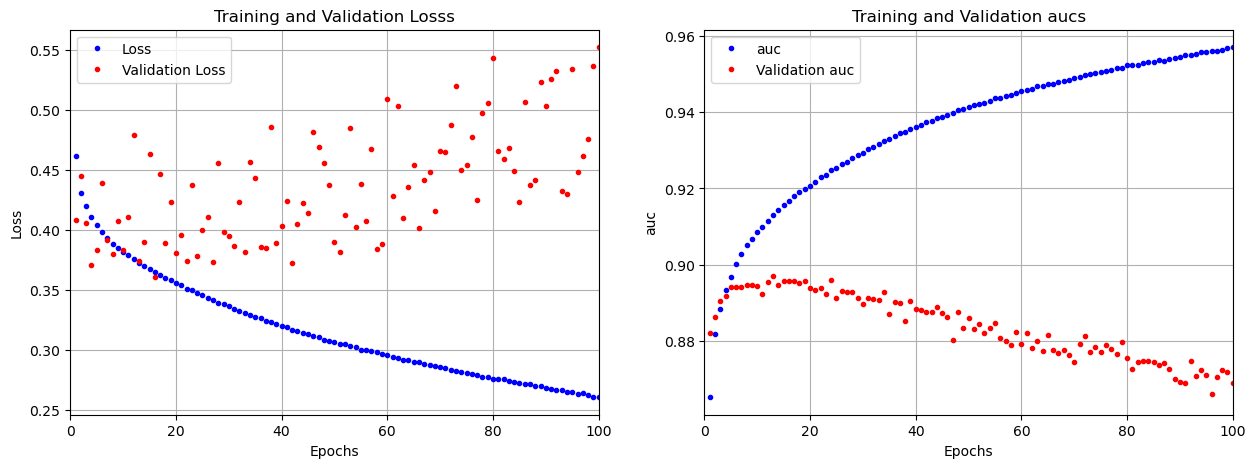

In [414]:
plot_training_history(trained_mlp_model['history'], monitors=['loss', 'auc'])

In [325]:
print('Accuracy (Validation): {:.2f} (baseline=0.77)'.format(trained_mlp_model['val_score'][0]))
print('Precision (Validation): {:.2f}'.format(trained_mlp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_mlp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_mlp_model['val_score'][3]))

Accuracy (Validation): 0.78 (baseline=0.77)
Precision (Validation): 0.50
Recall (Validation): 0.80
AUC (Validation): 0.87


In [410]:
preds = (trained_mlp_model['model'].predict(X_val, verbose=0) > 0.5).astype('int32')

print('Balanced Accuracy (Validation): {:.2f} (baseline = 0.5)'.format(balanced_accuracy_score(y_val, preds)))

Balanced Accuracy (Validation): 0.78 (baseline = 0.5)


 ## Regularizing your model and tuning your hyperparameters

In [357]:
# Compute Balanced Accuracy Score for Softmax One-Hot Encoded Output
def compute_balanced_accuracy_score(y, preds) :
    return balanced_accuracy_score(y, preds.flatten())

# Reformat Grid CV Stats to Dataframe
def to_dataframe(stats, mapping) :
    entries = []
    for param, metrics in stats.items() :
        entry = eval(param)
        for key, value in metrics.items() :
            entry[key] = value
        
        for key, value in mapping.items() :
            entry[value] = entry['scores'][key]
            
        entry.pop('scores') 
        
        entries.append( entry )

    return pd.DataFrame(data=entries)

In [362]:
# Grid Search CV
def grid_search_cv(X, y, class_weights, 
                   space, cv, 
                   optimizer, loss, metrics, 
                   epochs, callbacks=[], seed=0,
                   addon_metrics={}, order={}) :
    
    keys, values = zip(*space.items())
    
    stats = {}
    for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :
        kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
        
        scores, stopped, losses = [], [], []
        for train, validate in kfold.split(X, y) :
            model = deep_neural_network(hidden_layers=params['hidden_layers'], 
                                        hidden_neurons=params['neurons'], 
                                        activation=params['activation'], 
                                        dropout=params['dropout'], 
                                        input_dimension=X.shape[1], 
                                        output_dimension=1 if len(y.shape)<2 else y.shape[1],
                                        optimizer=optimizer, loss=loss, 
                                        metrics=metrics)
      
            trained = train_deep_neural_network(model, 
                                                X[train,:], y[train], 
                                                class_weights,
                                                batch_size=params['batch_size'], epochs=epochs, 
                                                val_data=(X[validate,:], y[validate]), 
                                                callbacks=callbacks, seed=seed) 
            
            evaluations = trained['model'].evaluate(X[validate,:], y[validate], verbose=0)[1:]
            for key, value in addon_metrics.items() :
                preds = (trained['model'].predict(X[validate,:], verbose=0) > 0.5).astype('int32')
                evaluations.append( value(y[validate], preds) )
                        
            scores.append( evaluations )
            stopped.append( len(trained['history'].history['val_loss']) )
            losses.append( np.min(trained['history'].history['val_loss']) )
        
        stats[str(params)] = { 'scores': np.mean(scores, axis=0), 
                               'epochs': np.mean(stopped), 
                               'val_loss': np.mean(losses) }
    
    return to_dataframe(stats, order)

In [363]:
addon_metrics = {'balanced_accuracy': balanced_accuracy_score}

orders = {
    0: 'accuracy',              
    1: 'precision',
    2: 'recall',
    3: 'auc',
    4: 'balanced_accuracy'
}

In [364]:
KFOLDS = 5

In [365]:
params = {
    'hidden_layers': [2, 3],
    'neurons': [80],
    'activation': ['relu'],
    'dropout': [0.25, 0.5],
    'batch_size': [512]
}

stats = grid_search_cv(X_train, y_train,  
                       class_weights=CLASS_WEIGHTS,
                       space=params, cv=KFOLDS, 
                       optimizer=OPTIMIZER, loss=LOSS_FUNC, metrics=METRICS, 
                       epochs=EPOCHS, callbacks=[EARLY_STOP], seed=SEED,
                       addon_metrics=addon_metrics, order=orders)

In [416]:
stats.sort_values(by=['auc'], ascending=False)

,hidden_layers,neurons,activation,dropout,batch_size,epochs,val_loss,accuracy,precision,recall,auc,balanced_accuracy
1,2,80,relu,0.50,512,26.2,0.393567,0.815924,0.563465,0.795375,0.893613,0.808618
2,3,80,relu,0.25,512,19.4,0.389583,0.813352,0.558821,0.796003,0.892705,0.807184
0,2,80,relu,0.25,512,16.6,0.389708,0.817341,0.566737,0.789012,0.891820,0.807269
3,3,80,relu,0.50,512,16.6,0.403549,0.810348,0.554275,0.787667,0.886370,0.802284


In [397]:
opt_model = deep_neural_network(hidden_layers=2, hidden_neurons=80,
                                dropout=0.5, activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_DIMENSION,
                                optimizer=OPTIMIZER, loss=LOSS_FUNC, 
                                metrics=METRICS,
                                name='Deep_Network')

opt_model.summary()

Model: "Deep_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_253 (Dense)           (None, 80)                9600      
                                                                 
 dropout_140 (Dropout)       (None, 80)                0         
                                                                 
 dense_254 (Dense)           (None, 80)                6480      
                                                                 
 dropout_141 (Dropout)       (None, 80)                0         
                                                                 
 dense_255 (Dense)           (None, 1)                 81        
                                                                 
Total params: 16,161
Trainable params: 16,161
Non-trainable params: 0
_________________________________________________________________


In [398]:
trained_opt_model = train_deep_neural_network(opt_model, X_train, y_train,
                                              CLASS_WEIGHTS,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

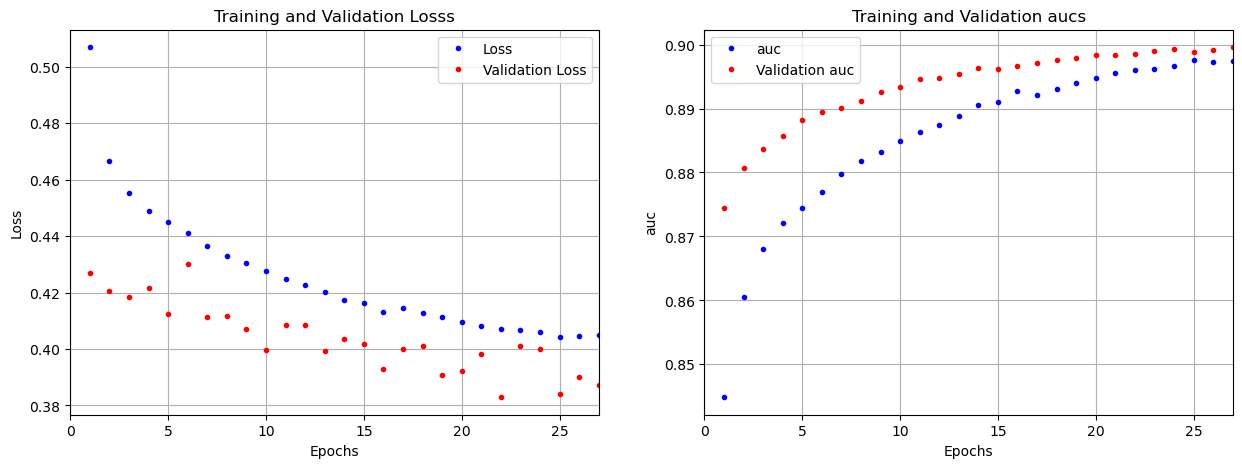

In [417]:
plot_training_history(trained_opt_model['history'], monitors=['loss', 'auc'])

In [400]:
print('Accuracy (Validation): {:.2f} (baseline=0.77)'.format(trained_opt_model['val_score'][0]))
print('Precision (Validation): {:.2f}'.format(trained_opt_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_opt_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_opt_model['val_score'][3]))

Accuracy (Validation): 0.82 (baseline=0.77)
Precision (Validation): 0.57
Recall (Validation): 0.79
AUC (Validation): 0.90


In [413]:
preds = (trained_opt_model['model'].predict(X_val, verbose=0) > 0.5).astype('int32')

print('Balanced Accuracy (Validation): {:.2f} (baseline = 0.5)'.format(balanced_accuracy_score(y_val, preds)))

Balanced Accuracy (Validation): 0.81 (baseline = 0.5)


In [402]:
preds = trained_opt_model['model'].predict(X_test, verbose=0)

print('Accuracy (Test): {:.2f} (baseline=0.77)'.format(accuracy_score(y_test, (preds > 0.5).astype('int32'))))
print('Precision (Test): {:.2f}'.format(precision_score(y_test, (preds > 0.5).astype('int32'))))
print('Recall (Test): {:.2f}'.format(recall_score(y_test, (preds > 0.5).astype('int32'))))
print('AUC (Test): {:.2f}'.format(roc_auc_score(y_test, preds)))

Accuracy (Test): 0.82 (baseline=0.77)
Precision (Test): 0.58
Recall (Test): 0.79
AUC (Test): 0.90


In [412]:
print('Balanced Accuracy (Test): {:.2f} (baseline = 0.5)'.format(balanced_accuracy_score(y_test, 
                                                                                               (preds > 0.5).astype('int32'))))

Balanced Accuracy (Test): 0.50 (baseline = 0.5)


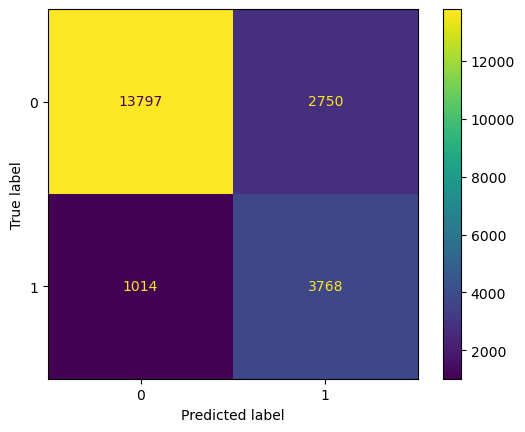

In [404]:
disp = ConfusionMatrixDisplay( confusion_matrix(y_test, (preds > 0.5).astype('int32')))
_ = disp.plot()